In [6]:

# ===== Cell 0: imports ===================


import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score  # Add this import
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from typing import Dict, Tuple, Optional

In [8]:
# ===== Cell 1: imports & shared utilities (minimal & simple) =====


# Optional: nicer plot resolution
plt.rcParams["figure.dpi"] = 120

# Small constant to avoid 0/1 edge cases when taking logit
EPS = 1e-6

def _ensure_binary(y):
    """
    Make sure labels are 0/1 and return a numpy array.
    Why: prevents silent bugs if labels are strings/floats or have stray values.
    """
    arr = pd.to_numeric(y, errors="coerce").fillna(0).astype(int).values
    bad = set(np.unique(arr)) - {0, 1}
    if bad:
        raise ValueError(f"Labels must be 0/1; found {bad}.")
    return arr

def _safe_prob(p, eps=EPS):
    """
    Convert to float and clip probabilities to (eps, 1-eps).
    Why: keeps values valid and avoids exact 0/1 that break logit math.
    Note: after cleaning, you shouldn't have NaNs here.
    """
    return np.clip(pd.to_numeric(p, errors="coerce").values, eps, 1 - eps)

def _safe_logit(p, eps=EPS):
    """
    Probabilities -> logits with clipping: log(p/(1-p)).
    Why: avoids ±inf if any p is 0 or 1.
    """
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    return np.log(p / (1 - p))



In [12]:
# ===== Cell 2: cleaning (super simple) =====
def clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Very simple cleaner:
      1) Show how many rows and how many miss the score/label
      2) Keep only rows that have BOTH
      3) Make sure the score is in [0,1] and the label is 0/1
      4) Print after-cleaning summary
    """
    print("=== CLEANING ===")
    print(f"Rows BEFORE: {len(df):,}")
    miss_prob = int(df[prob_col].isna().sum())
    miss_lbl  = int(df[y_col].isna().sum())
    print(f"Missing {prob_col}: {miss_prob:,}")
    print(f"Missing {y_col}: {miss_lbl:,}")

    # Keep rows that have both a score and a label
    out = df.loc[df[prob_col].notna() & df[y_col].notna()].copy()

    # Make types clean and safe
    out[prob_col] = pd.to_numeric(out[prob_col], errors="coerce").astype(float).clip(0, 1)
    out[y_col]    = pd.to_numeric(out[y_col], errors="coerce").astype(int)

    # Drop any row that became NaN during coercion (rare)
    out = out.dropna(subset=[prob_col, y_col])

    kept = len(out)
    print("\n=== AFTER CLEANING ===")
    print(f"Rows AFTER : {kept:,}  (kept {kept/len(df):.1%} of original)")
    if kept > 0:
        lbl_vals = sorted(pd.Series(out[y_col]).unique().tolist())
        print(f"Label values present: {lbl_vals}")
        print(f"Prevalence (mean of {y_col}): {out[y_col].mean():.4f}")
        print(f"{prob_col}: mean={out[prob_col].mean():.4f}, min={out[prob_col].min():.4f}, max={out[prob_col].max():.4f}")
        print("\nPreview (first 3 rows of score+label):")
        print(out[[prob_col, y_col]].head(3))
    return out


In [14]:
df = pd.read_csv('dataset/ed/finals/16_finalwithsigmoid.csv')
# Call _ensure_binary on the label column (must be 0/1)



assert "mortality_prob" in df.columns
assert "died_within_30_days" in df.columns

df_clean = clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days")

y = _ensure_binary(df["died_within_30_days"])

# Call _safe_prob on mortality_prob (clips to (1e-6, 1-1e-6) and coerces to float)
p = _safe_prob(df["mortality_prob"])

# Call _safe_logit on those probabilities (safe finite logits)
z = _safe_logit(p)

=== CLEANING ===
Rows BEFORE: 591,892
Missing mortality_prob: 358,997
Missing died_within_30_days: 0

=== AFTER CLEANING ===
Rows AFTER : 232,895  (kept 39.3% of original)
Label values present: [0, 1]
Prevalence (mean of died_within_30_days): 0.0222
mortality_prob: mean=0.0163, min=0.0000, max=0.9417

Preview (first 3 rows of score+label):
   mortality_prob  died_within_30_days
0        0.003980                    0
3        0.010333                    0
4        0.002620                    0


In [16]:
# ===== Cell 3: y_true / y_prob from CLEAN data =====
y_true = _ensure_binary(df_clean["died_within_30_days"])
y_prob = _safe_prob(df_clean["mortality_prob"])

print(f"n={len(y_true)}, prevalence={y_true.mean():.4f}")
print(pd.DataFrame({"y_true": y_true, "y_prob": y_prob}).head(5))


n=232895, prevalence=0.0222
   y_true    y_prob
0       0  0.003980
1       0  0.010333
2       0  0.002620
3       0  0.003980
4       0  0.024288


In [18]:
# ===== Cell 4: threshold and predictions =====
THRESHOLD = 0.50  # try 0.3, 0.4, 0.6, etc.
y_pred = (y_prob >= THRESHOLD).astype(int)

print("Preview (first 10):")
print(pd.DataFrame({"y_true": y_true[:10], "y_prob": y_prob[:10].round(3), "y_pred": y_pred[:10]}))


Preview (first 10):
   y_true  y_prob  y_pred
0       0   0.004       0
1       0   0.010       0
2       0   0.003       0
3       0   0.004       0
4       0   0.024       0
5       0   0.004       0
6       0   0.000       0
7       0   0.001       0
8       0   0.000       0
9       0   0.005       0


In [20]:
# ===== Cell 5: confusion matrix + metrics =====
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

metrics = {
    "TP": tp,
    "FP": fp,
    "TN": tn,
    "FN": fn,
    "Accuracy": accuracy_score(y_true, y_pred),
    "Sensitivity (Recall, TPR)": recall_score(y_true, y_pred, zero_division=0),
    "Specificity (TNR)": tn / (tn + fp) if (tn + fp) else float("nan"),
    "Precision (PPV)": precision_score(y_true, y_pred, zero_division=0),
    "F1": f1_score(y_true, y_pred, zero_division=0),
}

pd.DataFrame(metrics, index=["value"]).T.round(4)


,value
TP,302.0000
FP,128.0000
TN,227594.0000
FN,4871.0000
Accuracy,0.9785
"Sensitivity (Recall, TPR)",0.0584
Specificity (TNR),0.9994
Precision (PPV),0.7023
F1,0.1078


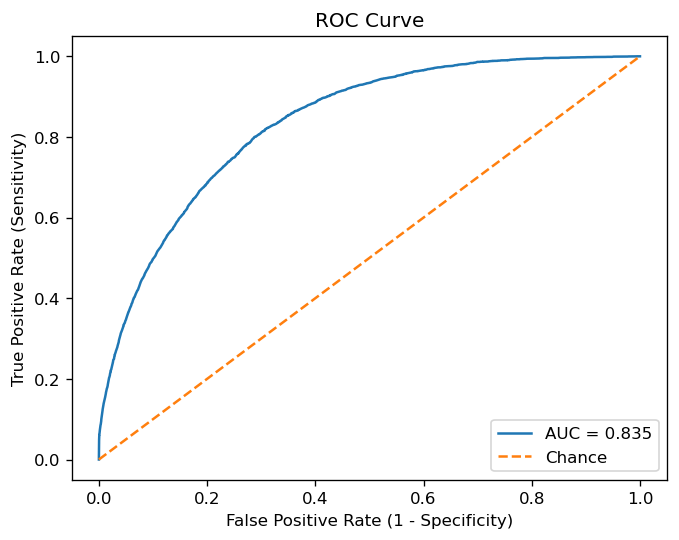

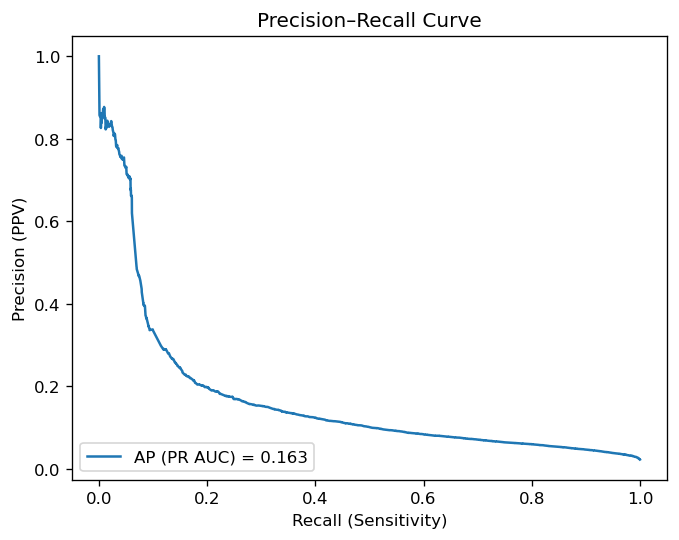

In [22]:
# ===== Cell 6: ROC/PR curves and AUCs =====
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", label="Chance")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

plt.figure()
plt.plot(rec, prec, label=f"AP (PR AUC) = {pr_auc:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.show()


Best by F1:
 threshold           0.100000
recall              0.217669
specificity         0.978562
precision           0.187417
f1                  0.201413
youdenJ             0.196230
TP               1126.000000
FP               4882.000000
TN             222840.000000
FN               4047.000000
Name: 10, dtype: float64 

Best by Youden’s J:
 threshold           0.010000
recall              0.822153
specificity         0.688392
precision           0.056546
f1                  0.105814
youdenJ             0.510545
TP               4253.000000
FP              70960.000000
TN             156762.000000
FN                920.000000
Name: 1, dtype: float64


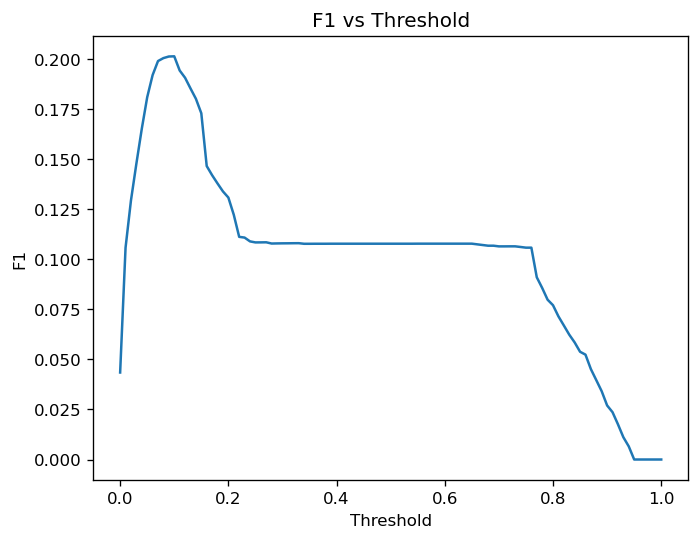

In [24]:
# ===== Cell 7: sweep thresholds to pick a good one =====
ths = np.linspace(0.0, 1.0, 101)
rows = []
for t in ths:
    yp = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0.0
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    f1   = 2*prec*sens/(prec+sens) if (prec+sens) else 0.0
    j    = sens + spec - 1  # Youden’s J
    rows.append((t, sens, spec, prec, f1, j, tp, fp, tn, fn))

th_df = pd.DataFrame(rows, columns=["threshold","recall","specificity","precision","f1","youdenJ","TP","FP","TN","FN"])
best_f1 = th_df.loc[th_df["f1"].idxmax()]
best_j  = th_df.loc[th_df["youdenJ"].idxmax()]

print("Best by F1:\n", best_f1, "\n")
print("Best by Youden’s J:\n", best_j)

# (Optional) quick plot of F1 across thresholds
plt.figure()
plt.plot(th_df["threshold"], th_df["f1"])
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("F1 vs Threshold")
plt.show()


In [26]:
# ===== Cell 8: reusable one-shot function =====
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef, roc_auc_score, average_precision_score

def compute_metrics(y_true, y_prob, threshold=0.5):
    y_true = _ensure_binary(y_true)
    y_prob = _safe_prob(y_prob)
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    out = {
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Sensitivity (Recall, TPR)": recall_score(y_true, y_pred, zero_division=0),
        "Specificity (TNR)": tn / (tn + fp) if (tn + fp) else float("nan"),
        "Precision (PPV)": precision_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Matthews Corr (MCC)": matthews_corrcoef(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob),
        "PR AUC (AP)": average_precision_score(y_true, y_prob),
        "Threshold": threshold,
    }
    return pd.DataFrame(out, index=["value"]).T

compute_metrics(df_clean["died_within_30_days"], df_clean["mortality_prob"], threshold=THRESHOLD).round(4)


,value
TP,302.0000
FP,128.0000
TN,227594.0000
FN,4871.0000
Accuracy,0.9785
"Sensitivity (Recall, TPR)",0.0584
Specificity (TNR),0.9994
Precision (PPV),0.7023
F1,0.1078
Balanced Accuracy,0.5289


In [30]:
def compute_metrics_by_group(df, y_col, prob_col, group_col, threshold=0.5):
    """
    Compute performance metrics (accuracy, recall, precision, F1, etc.)
    separately for each subgroup in `group_col`.
    """
    from sklearn.metrics import (
        confusion_matrix, accuracy_score, precision_score,
        recall_score, f1_score, roc_auc_score, average_precision_score
    )

    results = []
    for group, subdf in df.groupby(group_col):
        y_true = _ensure_binary(subdf[y_col])
        y_prob = _safe_prob(subdf[prob_col])
        y_pred = (y_prob >= threshold).astype(int)

        # confusion matrix safe unpack
        if len(np.unique(y_true)) < 2:
            # skip groups with only 0s or only 1s → metrics undefined
            continue

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        results.append({
            group_col: group,
            "n": len(subdf),
            "TP": tp, "FP": fp, "TN": tn, "FN": fn,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "Specificity": tn / (tn + fp) if (tn + fp) else float("nan"),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0),
            "ROC AUC": roc_auc_score(y_true, y_prob),
            "PR AUC": average_precision_score(y_true, y_prob),
        })

    return pd.DataFrame(results)


In [32]:
metrics_gender = compute_metrics_by_group(
    df_clean,
    y_col="died_within_30_days",
    prob_col="mortality_prob",
    group_col="gender",
    threshold=0.5
)

display(metrics_gender)


,gender,n,TP,FP,TN,FN,Accuracy,Recall,Specificity,Precision,F1,ROC AUC,PR AUC
0,F,136433,128,40,133926,2339,0.982563,0.051885,0.999701,0.761905,0.097154,0.850214,0.151153
1,M,96462,174,88,93668,2532,0.972839,0.064302,0.999061,0.664122,0.117251,0.811640,0.172518


In [34]:
metrics_gender = compute_metrics_by_group(
    df_clean,
    y_col="died_within_30_days",
    prob_col="mortality_prob",
    group_col="race_standard",
    threshold=0.5
)

display(metrics_gender)


,race_standard,n,TP,FP,TN,FN,Accuracy,Recall,Specificity,Precision,F1,ROC AUC,PR AUC
0,American Indian/Alaska Native,546,0,0,542,4,0.992674,0.000000,1.000000,0.000000,0.000000,0.786900,0.233247
1,Asian,10453,11,2,10206,234,0.977423,0.044898,0.999804,0.846154,0.085271,0.843281,0.155964
2,Black,53687,35,18,52986,648,0.987595,0.051245,0.999660,0.660377,0.095109,0.831906,0.117013
3,Hispanic/Latino,21868,12,1,21671,184,0.991540,0.061224,0.999954,0.923077,0.114833,0.837249,0.116474
4,Native Hawaiian/Pacific Islander,285,3,2,268,12,0.950877,0.200000,0.992593,0.600000,0.300000,0.897160,0.348320
5,Other/Unknown/Not Reported,14542,85,51,14051,355,0.972081,0.193182,0.996383,0.625000,0.295139,0.894001,0.329546
6,White,131424,156,54,127780,3434,0.973460,0.043454,0.999578,0.742857,0.082105,0.813999,0.153701


In [36]:
def compute_metrics_by_groups(df, y_col, prob_col, group_cols, threshold=0.5):
    """
    Compute performance metrics (accuracy, recall, precision, F1, AUCs)
    separately for subgroups defined by one or more columns.

    Parameters
    ----------
    df : DataFrame
    y_col : str
        Name of label column (0/1).
    prob_col : str
        Column of predicted probabilities.
    group_cols : str or list[str]
        Column(s) to group by (e.g. "gender" or ["gender","race_standard"]).
    threshold : float
        Cutoff for binary predictions.
    """
    from sklearn.metrics import (
        confusion_matrix, accuracy_score, precision_score,
        recall_score, f1_score, roc_auc_score, average_precision_score
    )

    if isinstance(group_cols, str):
        group_cols = [group_cols]

    results = []
    for keys, subdf in df.groupby(group_cols):
        # keys is tuple if multiple group_cols
        if not isinstance(keys, tuple):
            keys = (keys,)
        y_true = _ensure_binary(subdf[y_col])
        y_prob = _safe_prob(subdf[prob_col])
        y_pred = (y_prob >= threshold).astype(int)

        if len(np.unique(y_true)) < 2:
            # Skip groups with no positive or negative examples
            continue

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        results.append({
            **dict(zip(group_cols, keys)),
            "n": len(subdf),
            "TP": tp, "FP": fp, "TN": tn, "FN": fn,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "Specificity": tn / (tn + fp) if (tn + fp) else float("nan"),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0),
            "ROC AUC": roc_auc_score(y_true, y_prob),
            "PR AUC": average_precision_score(y_true, y_prob),
        })

    return pd.DataFrame(results)


In [38]:
metrics_gender_race = compute_metrics_by_groups(
    df_clean,
    y_col="died_within_30_days",
    prob_col="mortality_prob",
    group_cols=["gender", "race_standard"],
    threshold=0.5
)
display(metrics_gender_race)


,gender,race_standard,n,TP,FP,TN,FN,Accuracy,Recall,Specificity,Precision,F1,ROC AUC,PR AUC
0,F,American Indian/Alaska Native,312,0,0,311,1,0.996795,0.000000,1.000000,0.000000,0.000000,0.996785,0.500000
1,F,Asian,6184,5,1,6093,85,0.986093,0.055556,0.999836,0.833333,0.104167,0.856120,0.162686
2,F,Black,35195,13,10,34785,387,0.988720,0.032500,0.999713,0.565217,0.061466,0.843317,0.090323
3,F,Hispanic/Latino,13985,7,1,13892,85,0.993851,0.076087,0.999928,0.875000,0.140000,0.867033,0.109038
4,F,Native Hawaiian/Pacific Islander,143,2,1,139,1,0.986014,0.666667,0.992857,0.666667,0.666667,0.952381,0.601010
5,F,Other/Unknown/Not Reported,8469,26,16,8247,180,0.976857,0.126214,0.998064,0.619048,0.209677,0.908073,0.298871
6,F,White,72092,75,11,70406,1600,0.977654,0.044776,0.999844,0.872093,0.085179,0.828605,0.149656
7,M,American Indian/Alaska Native,234,0,0,231,3,0.987179,0.000000,1.000000,0.000000,0.000000,0.647908,0.181096
8,M,Asian,4269,6,1,4113,149,0.964863,0.038710,0.999757,0.857143,0.074074,0.804622,0.152835
9,M,Black,18492,22,8,18201,261,0.985453,0.077739,0.999561,0.733333,0.140575,0.808377,0.154328


In [40]:
def fairness_gaps(metrics_df, group_col, metric="Recall"):
    """
    Calculate min, max, and gap for a given metric across subgroups.
    """
    sub = metrics_df[[group_col, metric]].dropna()
    if sub.empty: 
        return None
    max_val = sub[metric].max()
    min_val = sub[metric].min()
    return {
        "metric": metric,
        "max": max_val,
        "min": min_val,
        "gap": max_val - min_val,
    }

# Example: gap in Recall and Precision across race groups
print(fairness_gaps(metrics_gender_race, "race_standard", metric="Recall"))
print(fairness_gaps(metrics_gender_race, "race_standard", metric="Precision"))


{'metric': 'Recall', 'max': 0.6666666666666666, 'min': 0.0, 'gap': 0.6666666666666666}
{'metric': 'Precision', 'max': 1.0, 'min': 0.0, 'gap': 1.0}


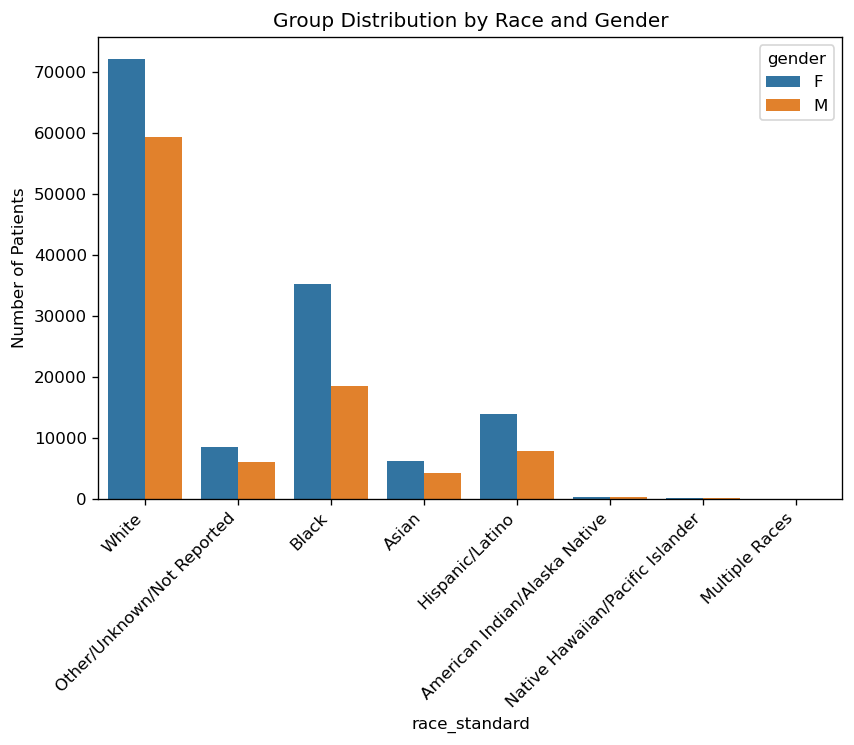

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simple barplot for group sizes
plt.figure(figsize=(8,5))
sns.countplot(data=df_clean, x="race_standard", hue="gender")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Patients")
plt.title("Group Distribution by Race and Gender")
plt.show()


AttributeError: Rectangle.set() got an unexpected keyword argument 'col'

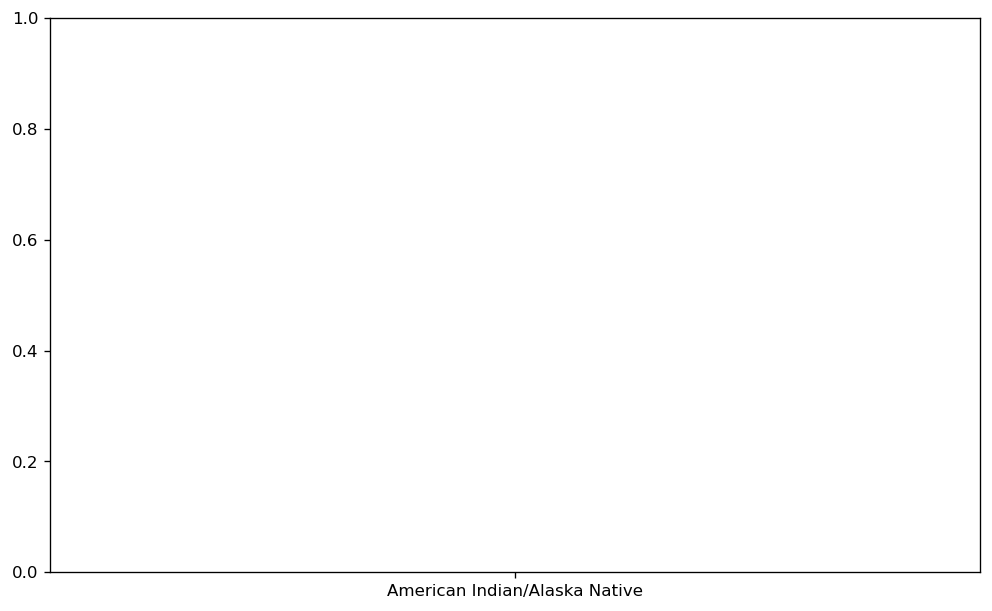

In [44]:
# metrics_gender_race = your intersectional metrics table
melted = metrics_gender_race.melt(
    id_vars=["gender","race_standard","n"],
    value_vars=["Recall","Precision"],
    var_name="Metric", value_name="Value"
)

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x="race_standard", y="Value", hue="gender", col="Metric")
sns.despine()
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1)
plt.title("Recall and Precision by Gender × Race")
plt.show()


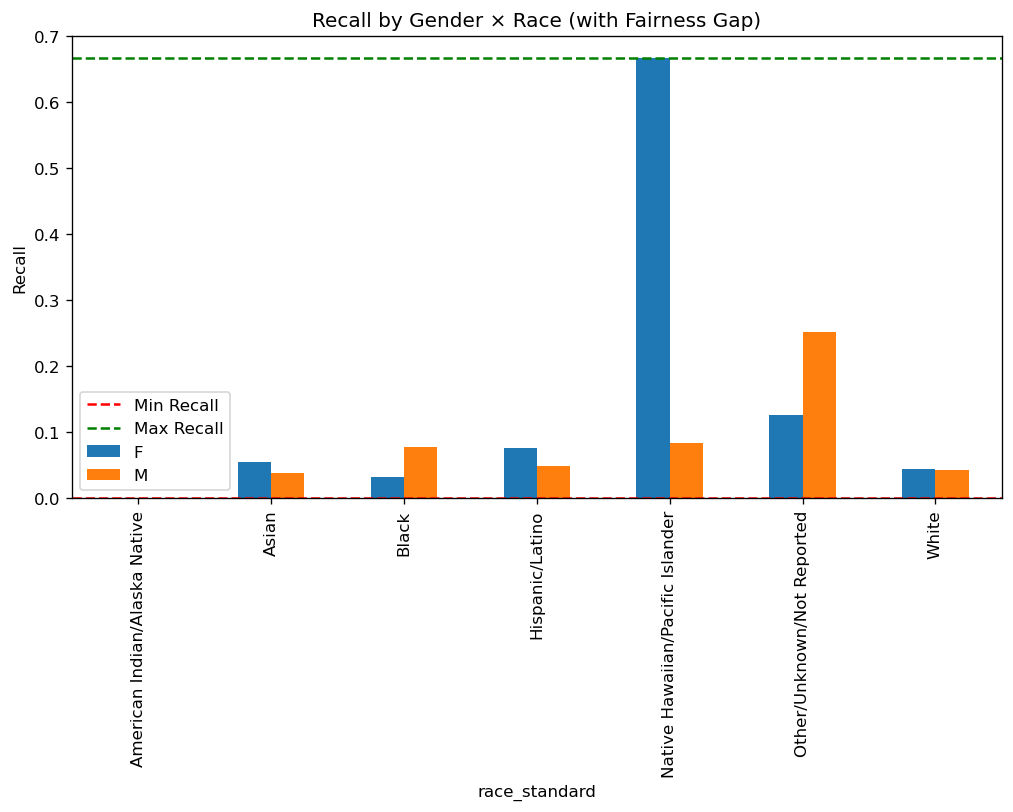

In [46]:
# For Recall only
recalls = metrics_gender_race.pivot(index="race_standard", columns="gender", values="Recall")
recalls.plot(kind="bar", figsize=(10,5))
plt.axhline(recalls.values.min(), color="red", linestyle="--", label="Min Recall")
plt.axhline(recalls.values.max(), color="green", linestyle="--", label="Max Recall")
plt.ylabel("Recall")
plt.title("Recall by Gender × Race (with Fairness Gap)")
plt.legend()
plt.show()


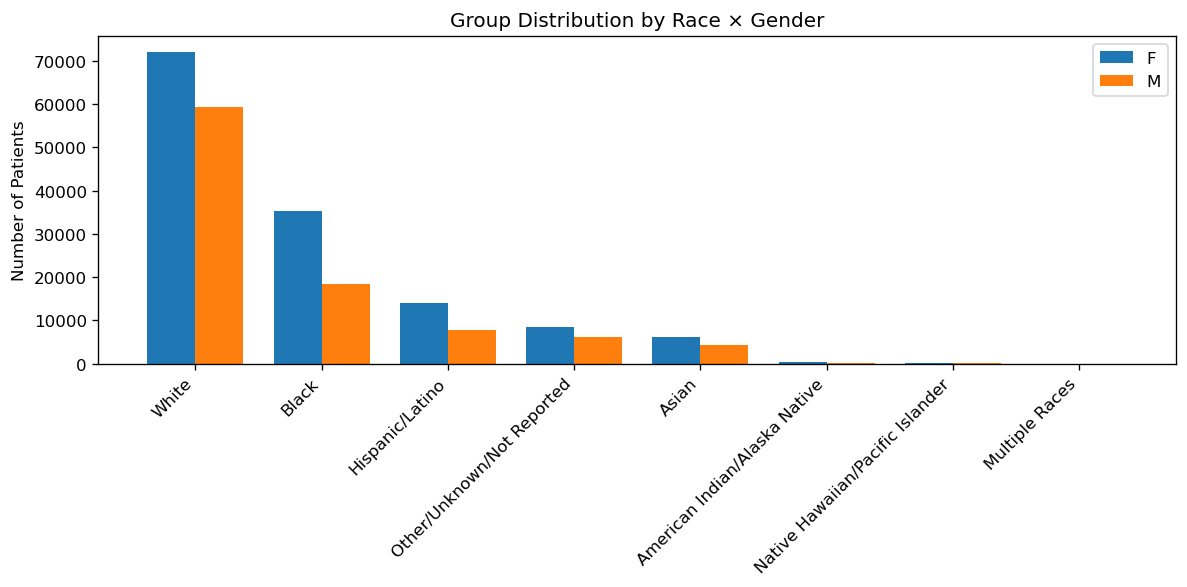

In [48]:
# ===== Plot 1: group sizes by race × gender =====
import numpy as np
import matplotlib.pyplot as plt

# Order races by total count (descending) for readability
race_order = (
    df_clean.groupby("race_standard")["died_within_30_days"]
    .size()
    .sort_values(ascending=False)
    .index.tolist()
)

# Build a simple count table (race x gender)
counts = (
    df_clean.groupby(["race_standard", "gender"])
    .size()
    .unstack(fill_value=0)
    .reindex(race_order)
)

# Ensure both columns exist (in case one gender is missing in your data)
for col in ["F", "M"]:
    if col not in counts.columns:
        counts[col] = 0

x = np.arange(len(counts.index))
width = 0.38

plt.figure(figsize=(10,5))
plt.bar(x - width/2, counts["F"].values, width, label="F")
plt.bar(x + width/2, counts["M"].values, width, label="M")
plt.xticks(x, counts.index, rotation=45, ha="right")
plt.ylabel("Number of Patients")
plt.title("Group Distribution by Race × Gender")
plt.legend()
plt.tight_layout()
plt.show()


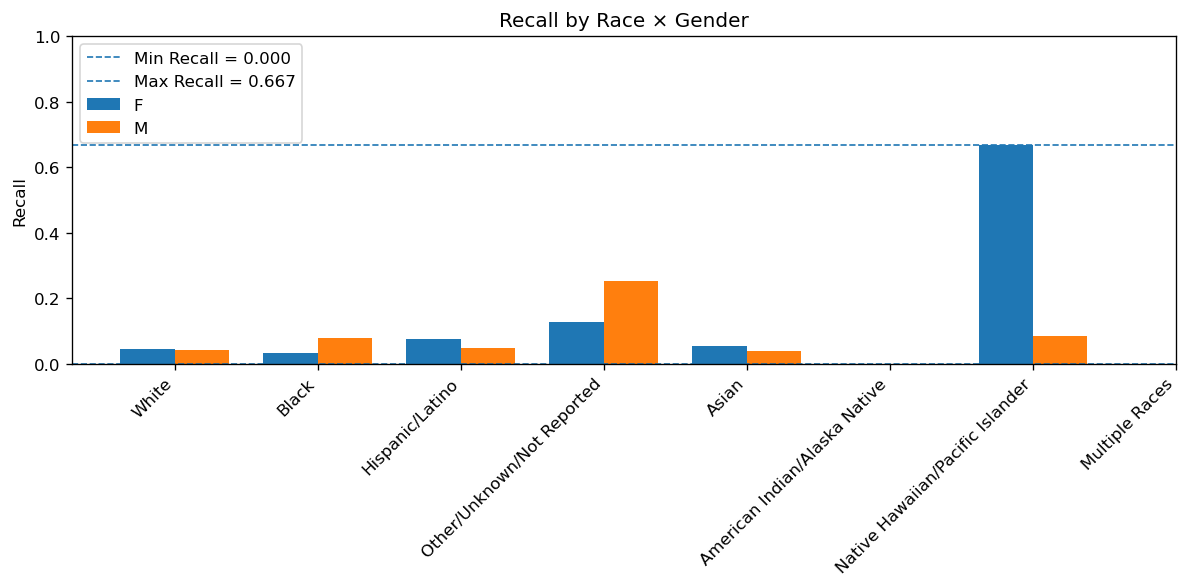

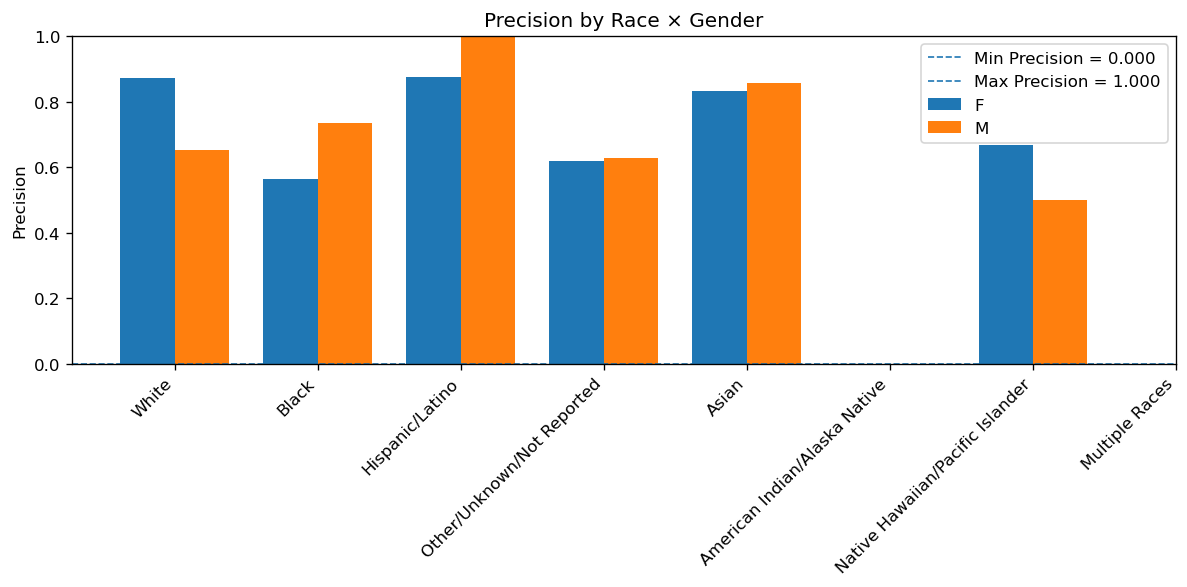

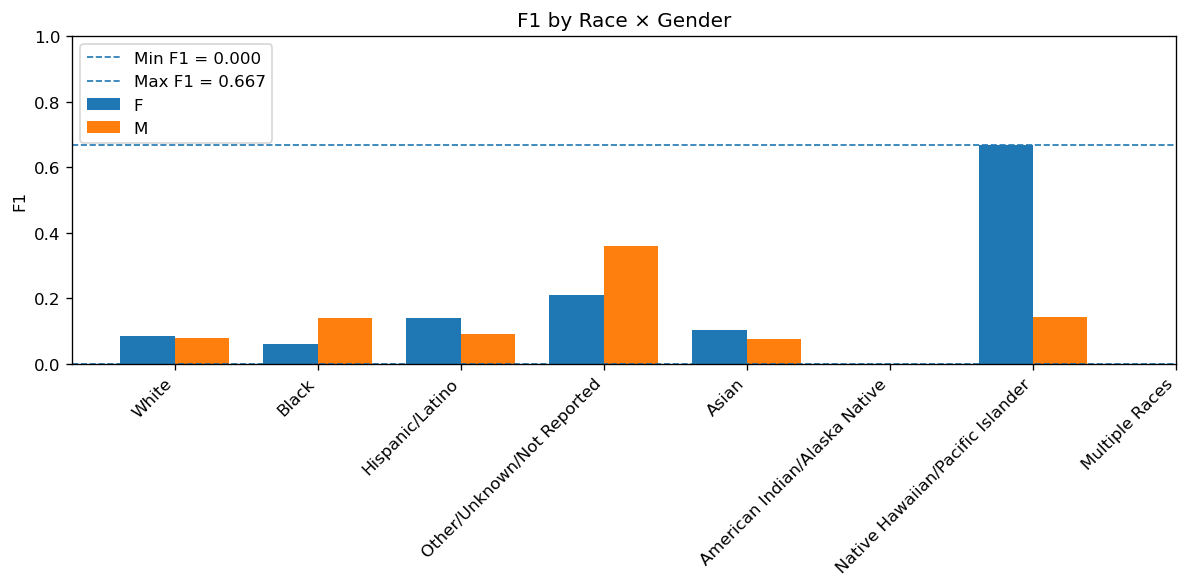

In [50]:
# ===== Plot 2: metrics by race × gender (Recall / Precision / F1) =====
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_by_race_gender(metrics_df, metric_name, order=None):
    """
    metrics_df: output from your intersectional table (gender × race_standard)
    metric_name: one of ["Recall","Precision","F1"] from that table
    order: optional list of race names to control x-axis order
    """
    # Pivot to race x gender
    pivot = metrics_df.pivot(index="race_standard", columns="gender", values=metric_name)
    if order is not None:
        pivot = pivot.reindex(order)
    # Ensure both F and M columns exist
    for col in ["F", "M"]:
        if col not in pivot.columns:
            pivot[col] = np.nan

    x = np.arange(len(pivot.index))
    width = 0.38
    fig, ax = plt.subplots(figsize=(10,5))

    ax.bar(x - width/2, pivot["F"].values, width, label="F")
    ax.bar(x + width/2, pivot["M"].values, width, label="M")

    # Fairness gap lines (min/max across all subgroups shown)
    vals = pivot.values.flatten()
    vals = vals[~np.isnan(vals)]
    if len(vals) > 0:
        vmin, vmax = np.min(vals), np.max(vals)
        ax.axhline(vmin, linestyle="--", linewidth=1, label=f"Min {metric_name} = {vmin:.3f}")
        ax.axhline(vmax, linestyle="--", linewidth=1, label=f"Max {metric_name} = {vmax:.3f}")

    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")
    ax.set_ylim(0, 1)  # metrics in [0,1]
    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name} by Race × Gender")
    ax.legend()
    fig.tight_layout()
    plt.show()

# Call it for your three main metrics
plot_metric_by_race_gender(metrics_gender_race, "Recall",    order=race_order)
plot_metric_by_race_gender(metrics_gender_race, "Precision", order=race_order)
plot_metric_by_race_gender(metrics_gender_race, "F1",        order=race_order)


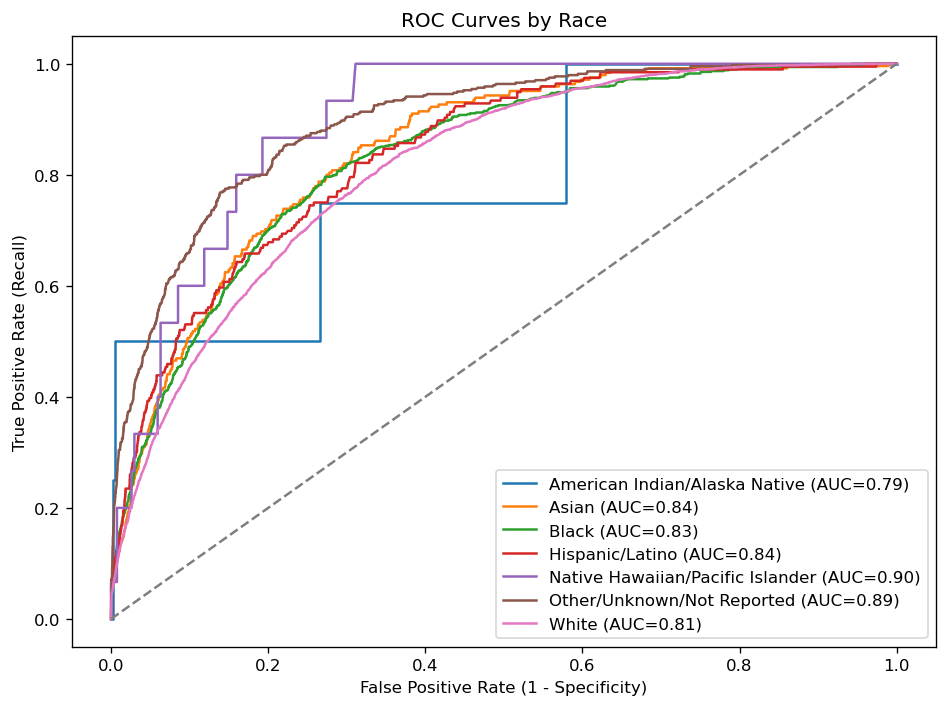

In [52]:
# ===== Plot 3 (optional): ROC curves by race =====
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8,6))
for race, subdf in df_clean.groupby("race_standard"):
    y_t = _ensure_binary(subdf["died_within_30_days"])
    y_p = _safe_prob(subdf["mortality_prob"])
    if len(np.unique(y_t)) < 2:
        continue  # skip if only one class present
    fpr, tpr, _ = roc_curve(y_t, y_p)
    auc_val = roc_auc_score(y_t, y_p)
    plt.plot(fpr, tpr, label=f"{race} (AUC={auc_val:.2f})")

plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves by Race")
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
# ===== Cell A: helpers for confusion-derived rates =====
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def confusion_terms(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn, fp, fn, tp

def rates_from_confusion(tn, fp, fn, tp):
    # Selection rate (P(\hat{Y}=1))
    sel = (tp + fp) / (tp + fp + tn + fn) if (tp + fp + tn + fn) else np.nan
    # True/False rates
    tpr = tp / (tp + fn) if (tp + fn) else np.nan  # Recall (Equal Opportunity uses this)
    fpr = fp / (fp + tn) if (fp + tn) else np.nan
    # Predictive values
    ppv = tp / (tp + fp) if (tp + fp) else np.nan  # Precision (Predictive Parity uses this)
    npv = tn / (tn + fn) if (tn + fn) else np.nan
    # Prevalence
    prev = (tp + fn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) else np.nan
    return dict(selection_rate=sel, tpr=tpr, fpr=fpr, ppv=ppv, npv=npv, prevalence=prev)


In [56]:
# ===== Cell B: compute group metrics and fairness gaps =====
def group_fairness_metrics(
    df, 
    y_col="died_within_30_days", 
    prob_col="mortality_prob", 
    group_cols=("gender",), 
    threshold=0.5
):
    """
    Returns:
      group_df: one row per subgroup with counts and rates
      gaps: dict of fairness gaps (max - min) and ratios (min/max) for key metrics
    """
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    rows = []
    for keys, sub in df.groupby(group_cols):
        keys = keys if isinstance(keys, tuple) else (keys,)
        y_true = _ensure_binary(sub[y_col])
        y_prob = _safe_prob(sub[prob_col])
        y_pred = (y_prob >= threshold).astype(int)

        # Skip degenerate groups (all positives or all negatives → TPR/FPR undefined)
        if len(np.unique(y_true)) < 2:
            continue

        tn, fp, fn, tp = confusion_terms(y_true, y_pred)
        rates = rates_from_confusion(tn, fp, fn, tp)
        rows.append({
            **dict(zip(group_cols, keys)),
            "n": len(sub),
            "TP": tp, "FP": fp, "TN": tn, "FN": fn,
            "selection_rate": rates["selection_rate"],
            "TPR": rates["tpr"],
            "FPR": rates["fpr"],
            "PPV": rates["ppv"],
            "NPV": rates["npv"],
            "prevalence": rates["prevalence"],
        })

    group_df = pd.DataFrame(rows)
    if group_df.empty:
        return group_df, {}

    # ---- Fairness gaps (max-min) and ratios (min/max) ----
    def gap_ratio(series):
        vals = series.dropna().values
        if len(vals) == 0:
            return np.nan, np.nan
        return float(np.max(vals) - np.min(vals)), (float(np.min(vals) / np.max(vals)) if np.max(vals) > 0 else np.nan)

    # Key fairness notions:
    # - Demographic Parity (DP): selection_rate equal across groups
    # - Equal Opportunity (EO): TPR equal across groups
    # - Equalized Odds (EOdds): TPR and FPR equal across groups
    # - Predictive Parity (PPV parity): PPV equal across groups
    gaps = {
        "DP_diff (max-min selection rate)": gap_ratio(group_df["selection_rate"])[0],
        "DP_ratio (min/max selection rate)": gap_ratio(group_df["selection_rate"])[1],
        "EO_diff (max-min TPR)": gap_ratio(group_df["TPR"])[0],
        "EO_ratio (min/max TPR)": gap_ratio(group_df["TPR"])[1],
        "EOdds_TPR_diff (max-min TPR)": gap_ratio(group_df["TPR"])[0],
        "EOdds_FPR_diff (max-min FPR)": gap_ratio(group_df["FPR"])[0],
        "PPV_parity_diff (max-min PPV)": gap_ratio(group_df["PPV"])[0],
        "PPV_parity_ratio (min/max PPV)": gap_ratio(group_df["PPV"])[1],
    }

    return group_df.sort_values(group_cols), gaps


In [58]:
# ===== Cell C: run fairness metrics =====

# 1) By gender
fair_gender, gaps_gender = group_fairness_metrics(
    df_clean, group_cols="gender", threshold=0.5
)
print("=== By gender: group metrics ===")
display(fair_gender)
print("\n=== By gender: fairness gaps ===")
print(gaps_gender)

# 2) By race
fair_race, gaps_race = group_fairness_metrics(
    df_clean, group_cols="race_standard", threshold=0.5
)
print("\n=== By race: group metrics ===")
display(fair_race)
print("\n=== By race: fairness gaps ===")
print(gaps_race)

# 3) Intersectional: gender × race
fair_gxR, gaps_gxR = group_fairness_metrics(
    df_clean, group_cols=["gender", "race_standard"], threshold=0.5
)
print("\n=== By gender × race: group metrics ===")
display(fair_gxR)
print("\n=== By gender × race: fairness gaps ===")
print(gaps_gxR)


=== By gender: group metrics ===


,gender,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,F,136433,128,40,133926,2339,0.001231,0.051885,0.000299,0.761905,0.982835,0.018082
1,M,96462,174,88,93668,2532,0.002716,0.064302,0.000939,0.664122,0.973680,0.028052



=== By gender: fairness gaps ===
{'DP_diff (max-min selection rate)': 0.001484721816004042, 'DP_ratio (min/max selection rate)': 0.4533616953611378, 'EO_diff (max-min TPR)': 0.012416671684865502, 'EO_ratio (min/max TPR)': 0.8068993472457123, 'EOdds_TPR_diff (max-min TPR)': 0.012416671684865502, 'EOdds_FPR_diff (max-min FPR)': 0.0006400233732358109, 'PPV_parity_diff (max-min PPV)': 0.09778262450018171, 'PPV_parity_ratio (min/max PPV)': 0.8716603053435115}

=== By race: group metrics ===


,race_standard,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,American Indian/Alaska Native,546,0,0,542,4,0.000000,0.000000,0.000000,NaN,0.992674,0.007326
1,Asian,10453,11,2,10206,234,0.001244,0.044898,0.000196,0.846154,0.977586,0.023438
2,Black,53687,35,18,52986,648,0.000987,0.051245,0.000340,0.660377,0.987918,0.012722
3,Hispanic/Latino,21868,12,1,21671,184,0.000594,0.061224,0.000046,0.923077,0.991581,0.008963
4,Native Hawaiian/Pacific Islander,285,3,2,268,12,0.017544,0.200000,0.007407,0.600000,0.957143,0.052632
5,Other/Unknown/Not Reported,14542,85,51,14051,355,0.009352,0.193182,0.003617,0.625000,0.975357,0.030257
6,White,131424,156,54,127780,3434,0.001598,0.043454,0.000422,0.742857,0.973829,0.027316



=== By race: fairness gaps ===
{'DP_diff (max-min selection rate)': 0.017543859649122806, 'DP_ratio (min/max selection rate)': 0.0, 'EO_diff (max-min TPR)': 0.2, 'EO_ratio (min/max TPR)': 0.0, 'EOdds_TPR_diff (max-min TPR)': 0.2, 'EOdds_FPR_diff (max-min FPR)': 0.007407407407407408, 'PPV_parity_diff (max-min PPV)': 0.32307692307692315, 'PPV_parity_ratio (min/max PPV)': 0.6499999999999999}

=== By gender × race: group metrics ===


,gender,race_standard,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,F,American Indian/Alaska Native,312,0,0,311,1,0.000000,0.000000,0.000000,NaN,0.996795,0.003205
1,F,Asian,6184,5,1,6093,85,0.000970,0.055556,0.000164,0.833333,0.986242,0.014554
2,F,Black,35195,13,10,34785,387,0.000654,0.032500,0.000287,0.565217,0.988997,0.011365
3,F,Hispanic/Latino,13985,7,1,13892,85,0.000572,0.076087,0.000072,0.875000,0.993919,0.006578
4,F,Native Hawaiian/Pacific Islander,143,2,1,139,1,0.020979,0.666667,0.007143,0.666667,0.992857,0.020979
5,F,Other/Unknown/Not Reported,8469,26,16,8247,180,0.004959,0.126214,0.001936,0.619048,0.978640,0.024324
6,F,White,72092,75,11,70406,1600,0.001193,0.044776,0.000156,0.872093,0.977780,0.023234
7,M,American Indian/Alaska Native,234,0,0,231,3,0.000000,0.000000,0.000000,NaN,0.987179,0.012821
8,M,Asian,4269,6,1,4113,149,0.001640,0.038710,0.000243,0.857143,0.965040,0.036308
9,M,Black,18492,22,8,18201,261,0.001622,0.077739,0.000439,0.733333,0.985863,0.015304



=== By gender × race: fairness gaps ===
{'DP_diff (max-min selection rate)': 0.02097902097902098, 'DP_ratio (min/max selection rate)': 0.0, 'EO_diff (max-min TPR)': 0.6666666666666666, 'EO_ratio (min/max TPR)': 0.0, 'EOdds_TPR_diff (max-min TPR)': 0.6666666666666666, 'EOdds_FPR_diff (max-min FPR)': 0.007692307692307693, 'PPV_parity_diff (max-min PPV)': 0.5, 'PPV_parity_ratio (min/max PPV)': 0.5}


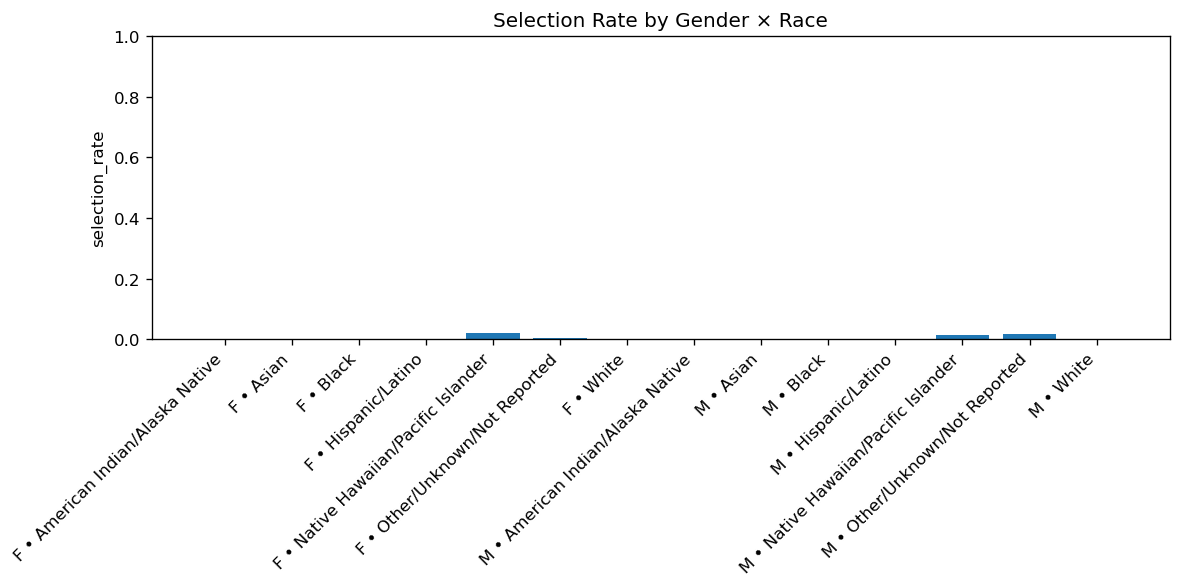

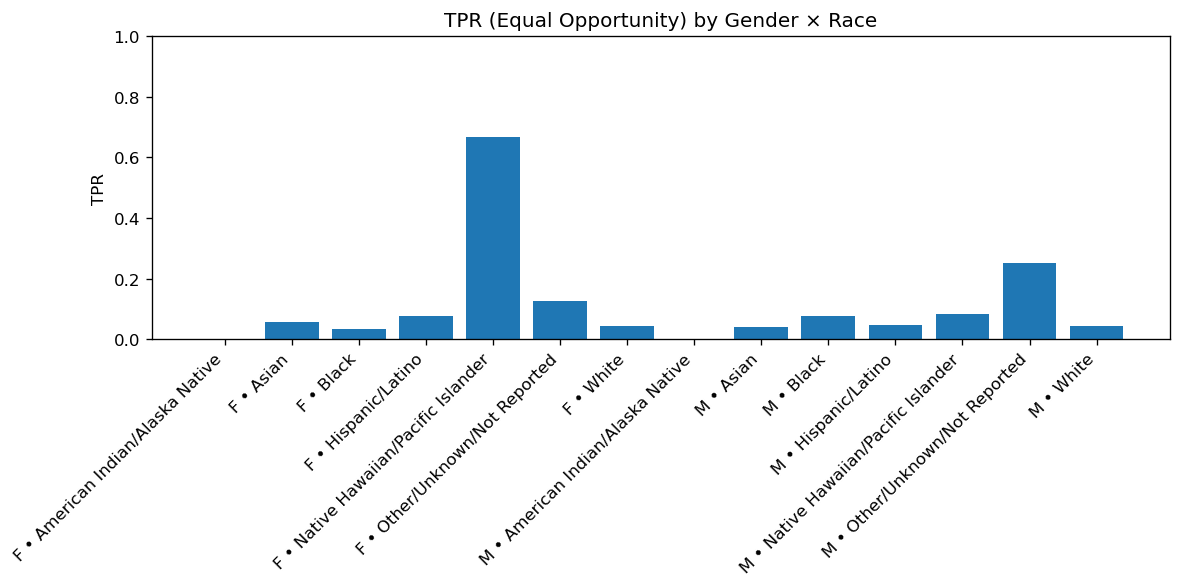

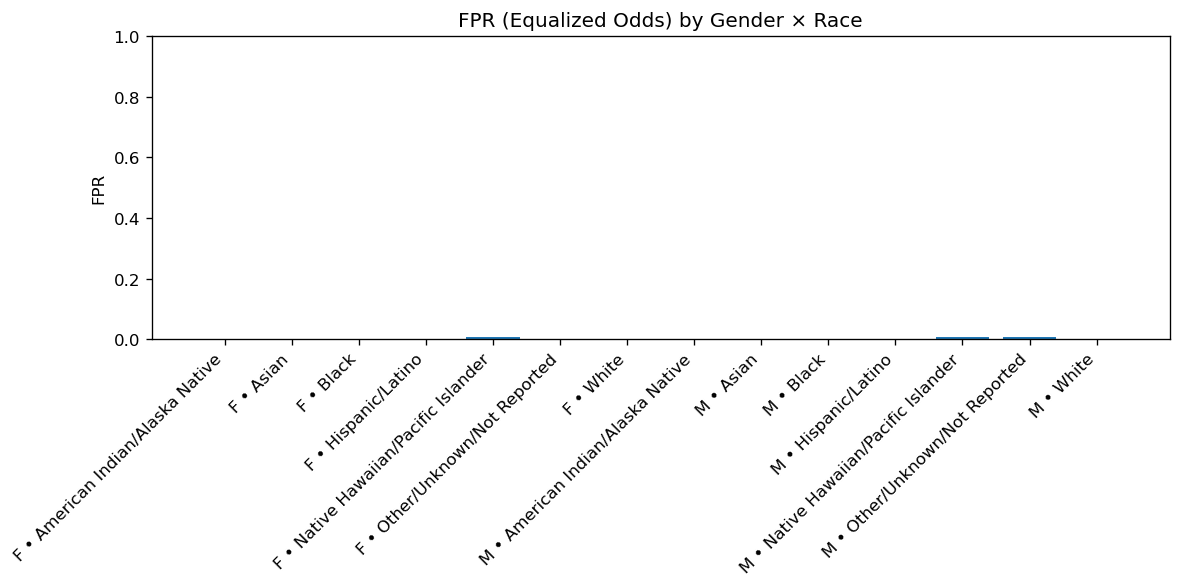

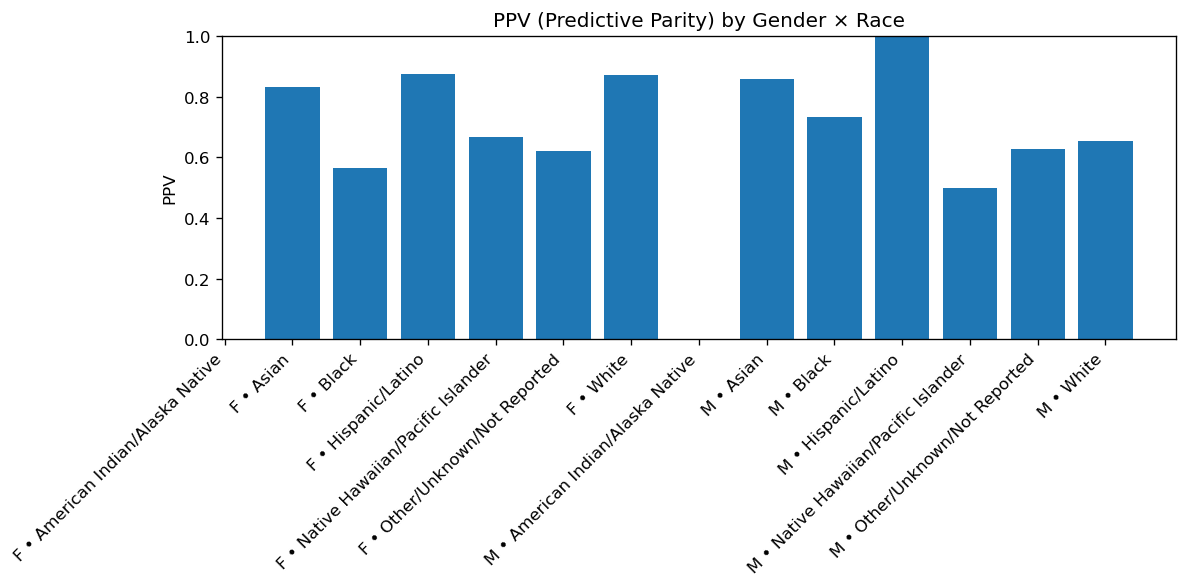

In [60]:
# ===== Cell D: simple bar plots for fairness metrics =====
import numpy as np
import matplotlib.pyplot as plt

def plot_group_metric(group_df, group_cols, metric, title=None):
    if isinstance(group_cols, str):
        group_cols = [group_cols]
    # Build a label per row like "F • White"
    labels = group_df[group_cols].astype(str).agg(" • ".join, axis=1).tolist()
    vals = group_df[metric].values

    x = np.arange(len(labels))
    plt.figure(figsize=(10,5))
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.title(title or metric)
    plt.tight_layout()
    plt.show()

# Example: visualize intersectional fairness metrics
plot_group_metric(fair_gxR, ["gender","race_standard"], "selection_rate", title="Selection Rate by Gender × Race")
plot_group_metric(fair_gxR, ["gender","race_standard"], "TPR",            title="TPR (Equal Opportunity) by Gender × Race")
plot_group_metric(fair_gxR, ["gender","race_standard"], "FPR",            title="FPR (Equalized Odds) by Gender × Race")
plot_group_metric(fair_gxR, ["gender","race_standard"], "PPV",            title="PPV (Predictive Parity) by Gender × Race")


In [62]:
# ===== Sweep thresholds and compute fairness gaps =====
import numpy as np
import pandas as pd

def sweep_fairness_gaps(
    df, y_col, prob_col, group_cols, thresholds=None
):
    """
    For each threshold, compute fairness gaps using group_fairness_metrics():
      - DP_diff (max-min selection rate)
      - DP_ratio (min/max selection rate)
      - EO_diff (max-min TPR)
      - EO_ratio (min/max TPR)
      - EOdds_FPR_diff (max-min FPR)
      - PPV_parity_diff (max-min PPV)
      - PPV_parity_ratio (min/max PPV)
    Returns a DataFrame (one row per threshold).
    """
    if thresholds is None:
        thresholds = np.linspace(0, 1, 101)

    rows = []
    for t in thresholds:
        _, gaps = group_fairness_metrics(
            df, y_col=y_col, prob_col=prob_col, group_cols=group_cols, threshold=t
        )
        rows.append({
            "threshold": t,
            "DP_diff": gaps.get("DP_diff (max-min selection rate)", np.nan),
            "DP_ratio": gaps.get("DP_ratio (min/max selection rate)", np.nan),
            "EO_diff": gaps.get("EO_diff (max-min TPR)", np.nan),
            "EO_ratio": gaps.get("EO_ratio (min/max TPR)", np.nan),
            "EOdds_FPR_diff": gaps.get("EOdds_FPR_diff (max-min FPR)", np.nan),
            "PPV_diff": gaps.get("PPV_parity_diff (max-min PPV)", np.nan),
            "PPV_ratio": gaps.get("PPV_parity_ratio (min/max PPV)", np.nan),
        })
    return pd.DataFrame(rows)


In [64]:
# ===== Plot fairness gaps vs threshold =====
import matplotlib.pyplot as plt

def plot_fairness_curves(sweep_df, title_prefix="Fairness Gaps"):
    """
    Plots EO_diff, DP_diff, EOdds_FPR_diff, PPV_diff vs threshold.
    """
    x = sweep_df["threshold"].values

    def _one(metric, ylabel):
        plt.figure(figsize=(7,4))
        plt.plot(x, sweep_df[metric].values, label=metric)
        plt.xlabel("Threshold")
        plt.ylabel(ylabel)
        plt.title(f"{title_prefix}: {metric}")
        plt.tight_layout()
        plt.show()

    _one("EO_diff", "Max-Min TPR (Equal Opportunity)")
    _one("DP_diff", "Max-Min Selection Rate (Demographic Parity)")
    _one("EOdds_FPR_diff", "Max-Min FPR (Equalized Odds)")
    _one("PPV_diff", "Max-Min PPV (Predictive Parity)")


In [66]:
# ===== Pick thresholds that reduce fairness gaps =====
def summarize_best_thresholds(sweep_df):
    """
    Prints candidate thresholds that:
      - minimize EO_diff
      - minimize DP_diff
      - minimize PPV_diff
      - minimize a combined score (EO_diff + DP_diff + PPV_diff), ignoring NaNs
    Returns a small DataFrame for convenience.
    """
    df = sweep_df.copy()

    def _best_idx(col):
        s = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if s.empty: 
            return None
        return s.idxmin()

    idx_eo  = _best_idx("EO_diff")
    idx_dp  = _best_idx("DP_diff")
    idx_ppv = _best_idx("PPV_diff")

    # Simple combined objective (you can change weights if you want)
    df["combined"] = df[["EO_diff","DP_diff","PPV_diff"]].replace([np.inf,-np.inf], np.nan).sum(axis=1, min_count=1)
    idx_combo = df["combined"].idxmin()

    rows = []
    for name, idx in [
        ("min_EO_diff", idx_eo),
        ("min_DP_diff", idx_dp),
        ("min_PPV_diff", idx_ppv),
        ("min_combined", idx_combo),
    ]:
        if idx is not None:
            rows.append({
                "which": name,
                "threshold": float(df.loc[idx, "threshold"]),
                "EO_diff": float(df.loc[idx, "EO_diff"]),
                "DP_diff": float(df.loc[idx, "DP_diff"]),
                "PPV_diff": float(df.loc[idx, "PPV_diff"]),
                "EOdds_FPR_diff": float(df.loc[idx, "EOdds_FPR_diff"]),
            })
    return pd.DataFrame(rows)


=== Best thresholds (gender) ===


,which,threshold,EO_diff,DP_diff,PPV_diff,EOdds_FPR_diff
0,min_EO_diff,0.00,0.000000,0.000000,0.009970,0.000000
1,min_DP_diff,0.00,0.000000,0.000000,0.009970,0.000000
2,min_PPV_diff,0.12,0.043688,0.012352,0.002298,0.010052
3,min_combined,0.00,0.000000,0.000000,0.009970,0.000000


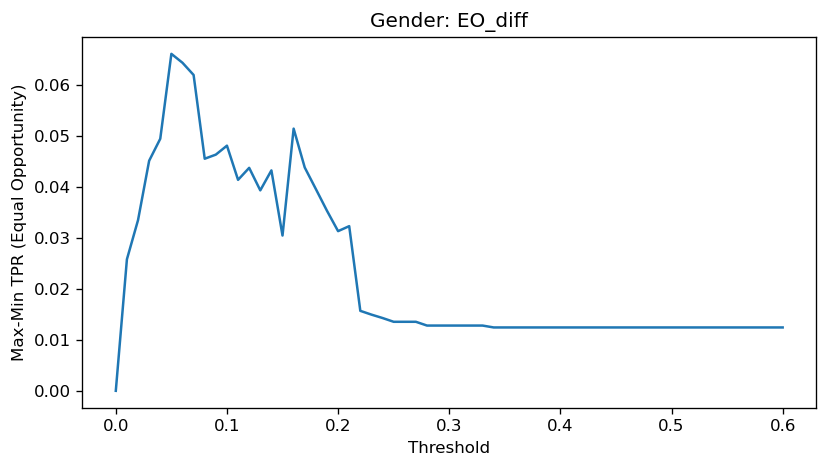

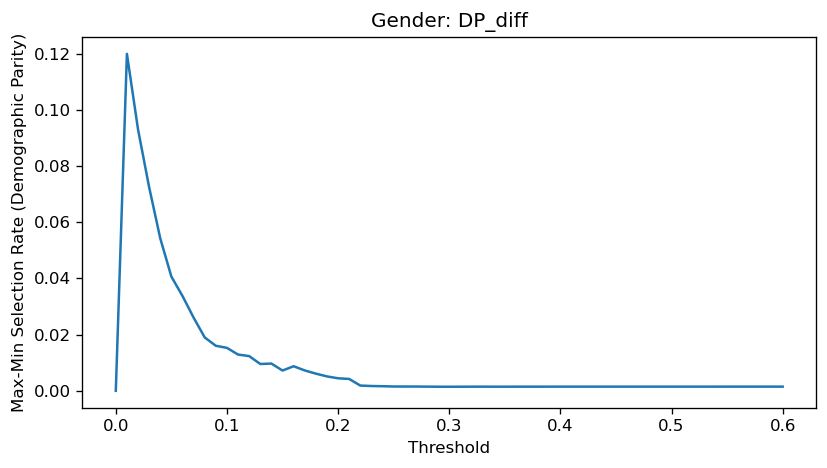

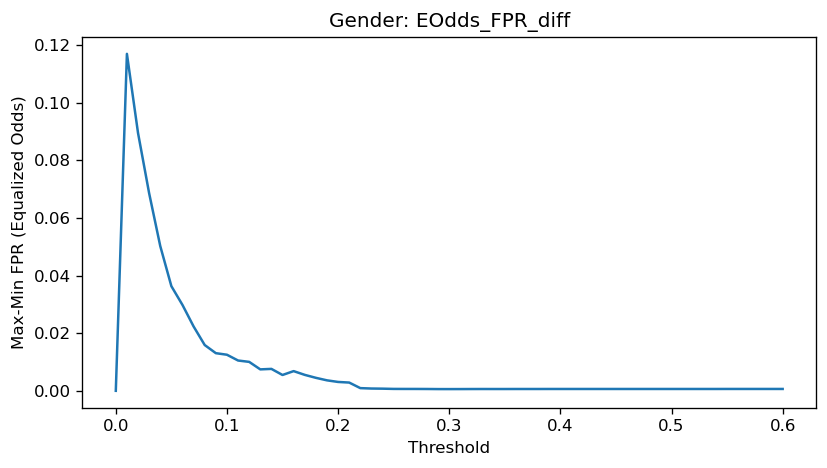

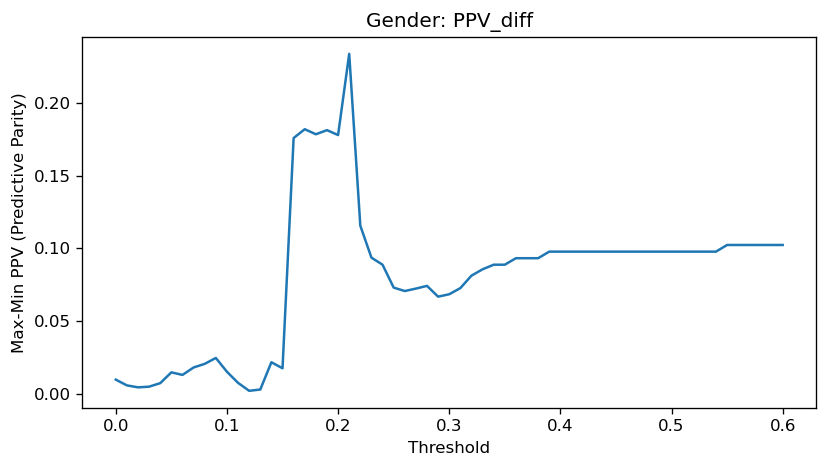

=== Best thresholds (race) ===


,which,threshold,EO_diff,DP_diff,PPV_diff,EOdds_FPR_diff
0,min_EO_diff,0.0,0.0,0.0,0.045306,0.0
1,min_DP_diff,0.0,0.0,0.0,0.045306,0.0
2,min_PPV_diff,0.0,0.0,0.0,0.045306,0.0
3,min_combined,0.0,0.0,0.0,0.045306,0.0


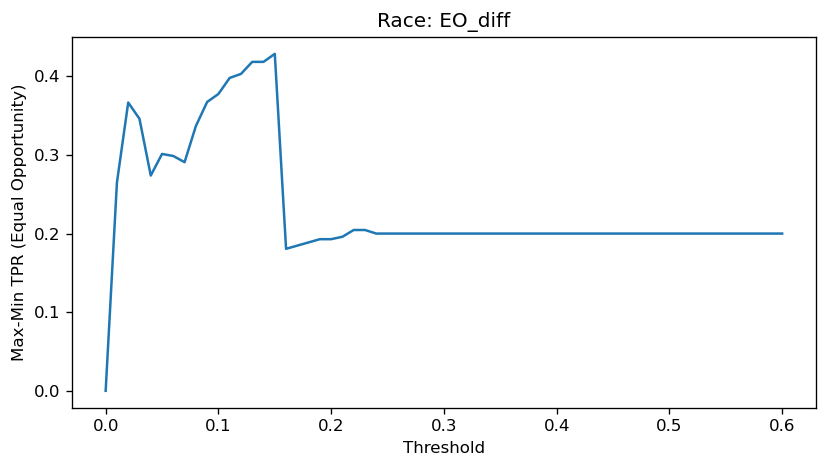

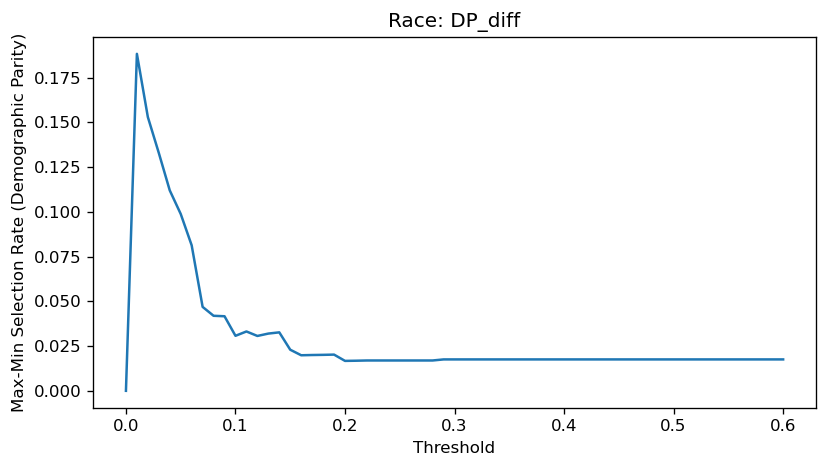

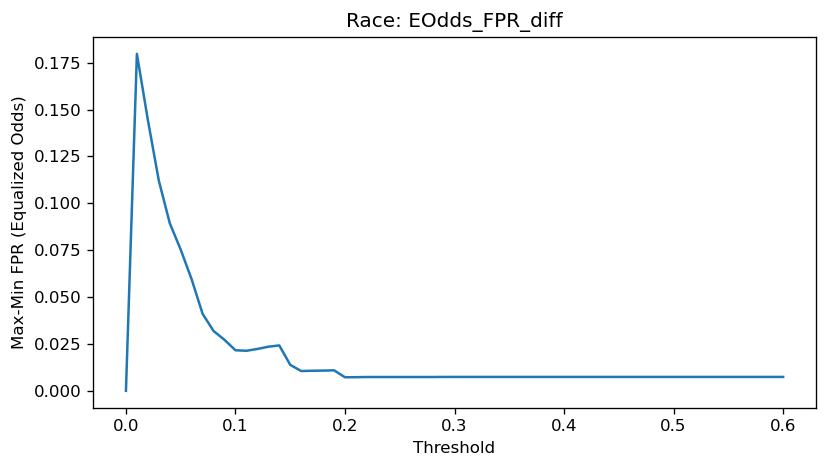

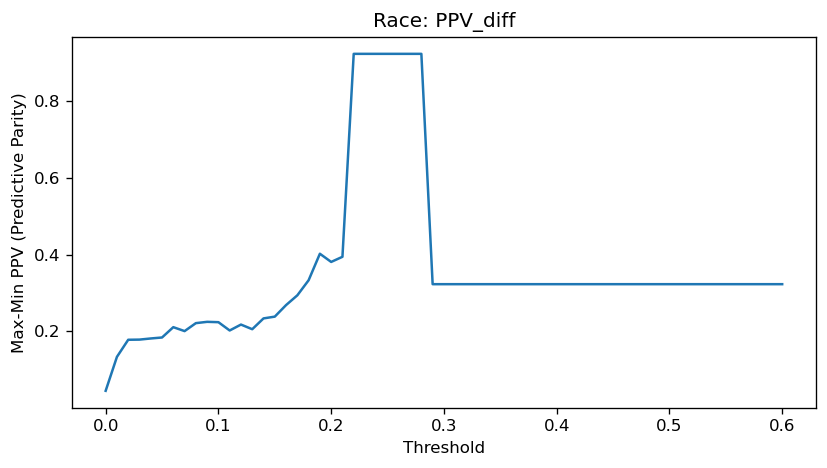

=== Best thresholds (gender × race) ===


,which,threshold,EO_diff,DP_diff,PPV_diff,EOdds_FPR_diff
0,min_EO_diff,0.0,0.0,0.0,0.081302,0.0
1,min_DP_diff,0.0,0.0,0.0,0.081302,0.0
2,min_PPV_diff,0.0,0.0,0.0,0.081302,0.0
3,min_combined,0.0,0.0,0.0,0.081302,0.0


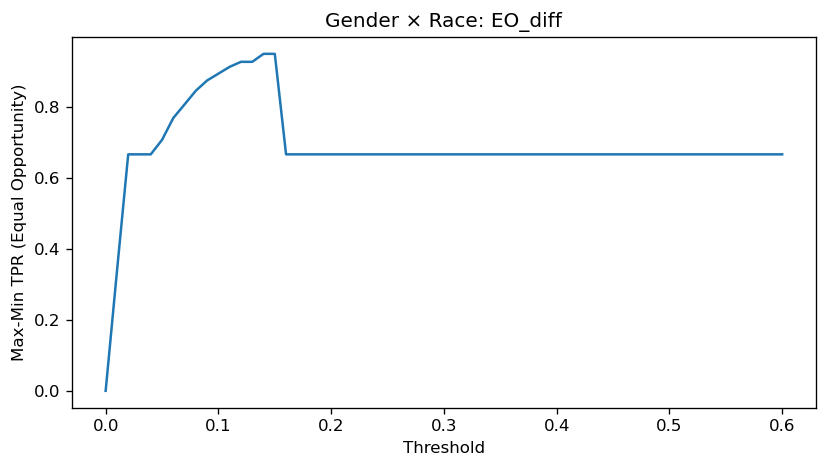

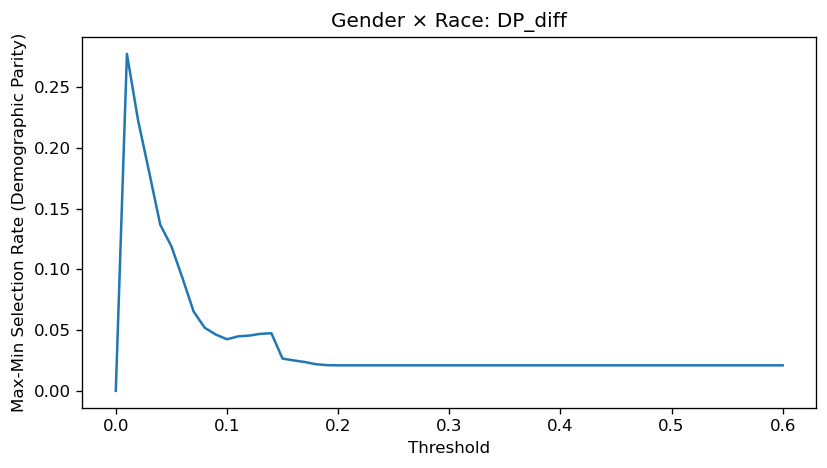

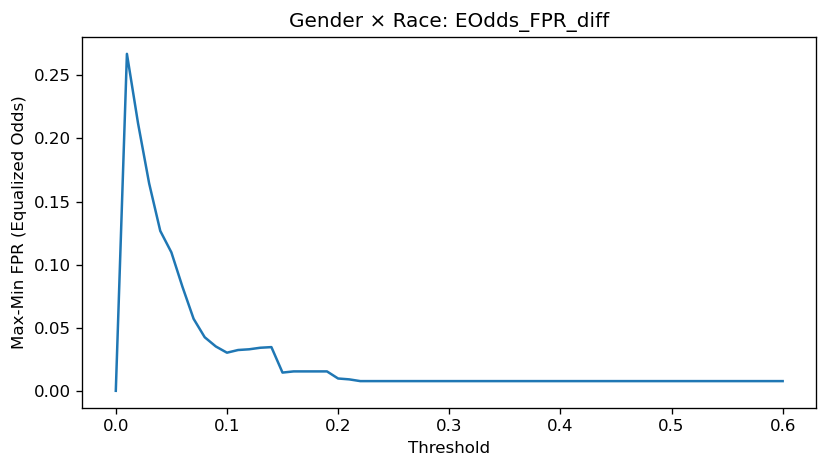

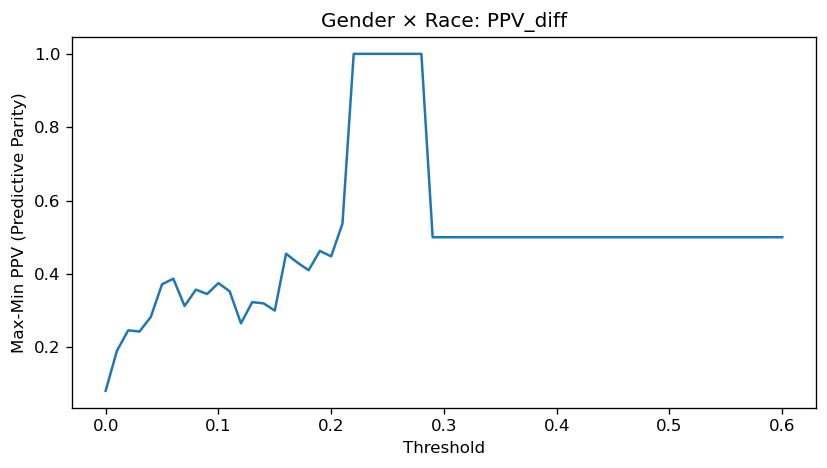

In [68]:
# ===== Run sweeps and plot =====

# 1) By gender
s_gender = sweep_fairness_gaps(
    df_clean, y_col="died_within_30_days", prob_col="mortality_prob",
    group_cols="gender", thresholds=np.linspace(0.0, 0.6, 61)  # focus low thresholds if recall is tiny
)
print("=== Best thresholds (gender) ===")
display(summarize_best_thresholds(s_gender))
plot_fairness_curves(s_gender, title_prefix="Gender")

# 2) By race
s_race = sweep_fairness_gaps(
    df_clean, y_col="died_within_30_days", prob_col="mortality_prob",
    group_cols="race_standard", thresholds=np.linspace(0.0, 0.6, 61)
)
print("=== Best thresholds (race) ===")
display(summarize_best_thresholds(s_race))
plot_fairness_curves(s_race, title_prefix="Race")

# 3) Intersectional: gender × race
s_gxR = sweep_fairness_gaps(
    df_clean, y_col="died_within_30_days", prob_col="mortality_prob",
    group_cols=["gender","race_standard"], thresholds=np.linspace(0.0, 0.6, 61)
)
print("=== Best thresholds (gender × race) ===")
display(summarize_best_thresholds(s_gxR))
plot_fairness_curves(s_gxR, title_prefix="Gender × Race")


In [69]:
# ===== Compare a few specific thresholds side by side =====
def fairness_at_thresholds(df, y_col, prob_col, group_cols, thresholds):
    rows = []
    for t in thresholds:
        _, gaps = group_fairness_metrics(
            df, y_col=y_col, prob_col=prob_col, group_cols=group_cols, threshold=t
        )
        rows.append({"threshold": t,
                     "DP_diff": gaps.get("DP_diff (max-min selection rate)"),
                     "EO_diff": gaps.get("EO_diff (max-min TPR)"),
                     "EOdds_FPR_diff": gaps.get("EOdds_FPR_diff (max-min FPR)"),
                     "PPV_diff": gaps.get("PPV_parity_diff (max-min PPV)")})
    return pd.DataFrame(rows)

compare_gender = fairness_at_thresholds(
    df_clean, "died_within_30_days", "mortality_prob", "gender",
    thresholds=[0.1, 0.2, 0.3, 0.4, 0.5]
)
print("=== Fairness (gender) at selected thresholds ===")
display(compare_gender)

compare_race = fairness_at_thresholds(
    df_clean, "died_within_30_days", "mortality_prob", "race_standard",
    thresholds=[0.1, 0.2, 0.3, 0.4, 0.5]
)
print("=== Fairness (race) at selected thresholds ===")
display(compare_race)

compare_gxR = fairness_at_thresholds(
    df_clean, "died_within_30_days", "mortality_prob", ["gender","race_standard"],
    thresholds=[0.1, 0.2, 0.3, 0.4, 0.5]
)
print("=== Fairness (gender×race) at selected thresholds ===")
display(compare_gxR)


=== Fairness (gender) at selected thresholds ===


,threshold,DP_diff,EO_diff,EOdds_FPR_diff,PPV_diff
0,0.1,0.015282,0.048035,0.012529,0.015372
1,0.2,0.004462,0.031287,0.003081,0.177759
2,0.3,0.001454,0.012786,0.000598,0.068550
3,0.4,0.001485,0.012417,0.000640,0.097783
4,0.5,0.001485,0.012417,0.000640,0.097783


=== Fairness (race) at selected thresholds ===


,threshold,DP_diff,EO_diff,EOdds_FPR_diff,PPV_diff
0,0.1,0.030731,0.377551,0.021622,0.224101
1,0.2,0.016721,0.192857,0.007223,0.381039
2,0.3,0.017544,0.200000,0.007407,0.323077
3,0.4,0.017544,0.200000,0.007407,0.323077
4,0.5,0.017544,0.200000,0.007407,0.323077


=== Fairness (gender×race) at selected thresholds ===


,threshold,DP_diff,EO_diff,EOdds_FPR_diff,PPV_diff
0,0.1,0.042444,0.894231,0.030211,0.375000
1,0.2,0.020979,0.666667,0.009762,0.447778
2,0.3,0.020979,0.666667,0.007692,0.500000
3,0.4,0.020979,0.666667,0.007692,0.500000
4,0.5,0.020979,0.666667,0.007692,0.500000


In [72]:
def format_fairness_gaps(gaps_dict):
    rows = []
    rows.append({
        "Fairness notion": "Demographic Parity",
        "Gap (max-min)": gaps_dict.get("DP_diff (max-min selection rate)"),
        "Ratio (min/max)": gaps_dict.get("DP_ratio (min/max selection rate)")
    })
    rows.append({
        "Fairness notion": "Equal Opportunity",
        "Gap (max-min)": gaps_dict.get("EO_diff (max-min TPR)"),
        "Ratio (min/max)": gaps_dict.get("EO_ratio (min/max TPR)")
    })
    rows.append({
        "Fairness notion": "Equalized Odds (TPR)",
        "Gap (max-min)": gaps_dict.get("EOdds_TPR_diff (max-min TPR)"),
        "Ratio (min/max)": None
    })
    rows.append({
        "Fairness notion": "Equalized Odds (FPR)",
        "Gap (max-min)": gaps_dict.get("EOdds_FPR_diff (max-min FPR)"),
        "Ratio (min/max)": None
    })
    rows.append({
        "Fairness notion": "Predictive Parity (PPV parity)",
        "Gap (max-min)": gaps_dict.get("PPV_parity_diff (max-min PPV)"),
        "Ratio (min/max)": gaps_dict.get("PPV_parity_ratio (min/max PPV)")
    })
    return pd.DataFrame(rows)

# Example: format gender gaps
fairness_gender_table = format_fairness_gaps(gaps_gender)
display(fairness_gender_table)


,Fairness notion,Gap (max-min),Ratio (min/max)
0,Demographic Parity,0.001485,0.453362
1,Equal Opportunity,0.012417,0.806899
2,Equalized Odds (TPR),0.012417,NaN
3,Equalized Odds (FPR),0.000640,NaN
4,Predictive Parity (PPV parity),0.097783,0.871660


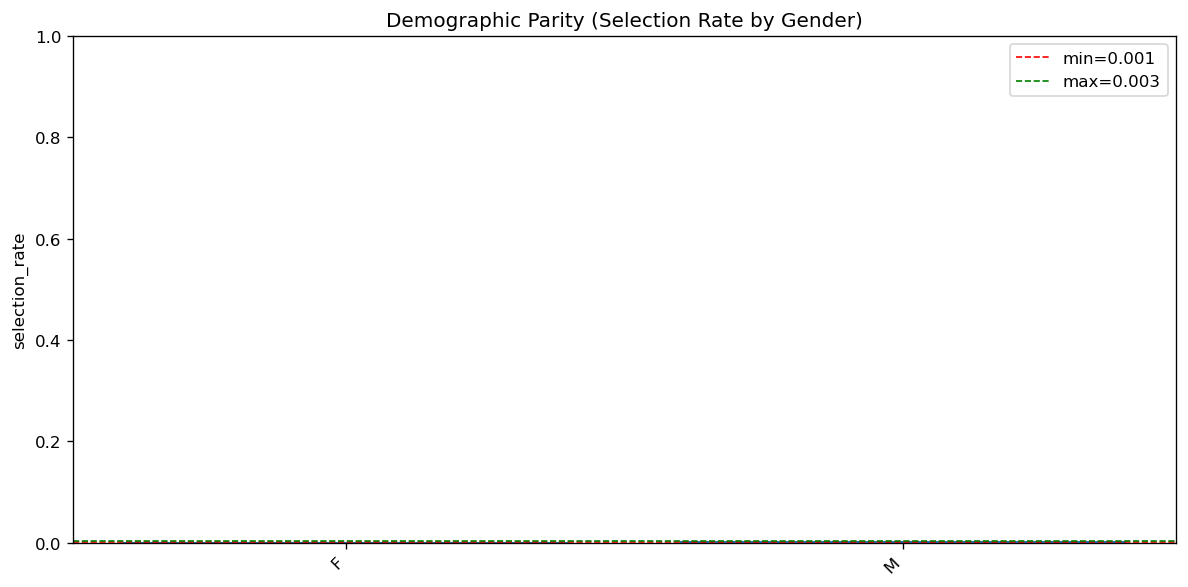

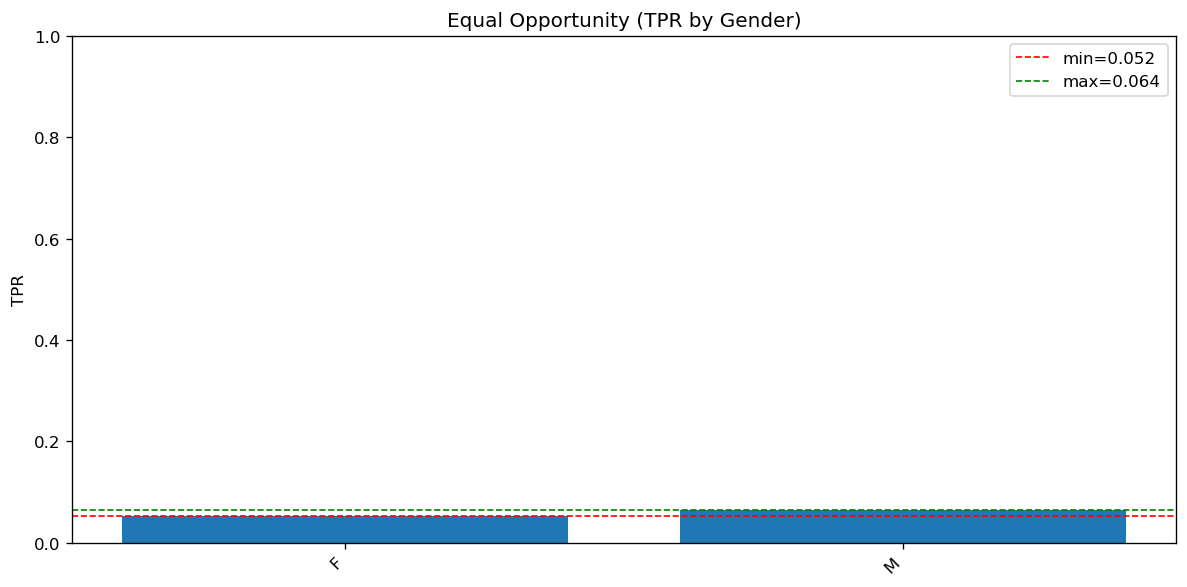

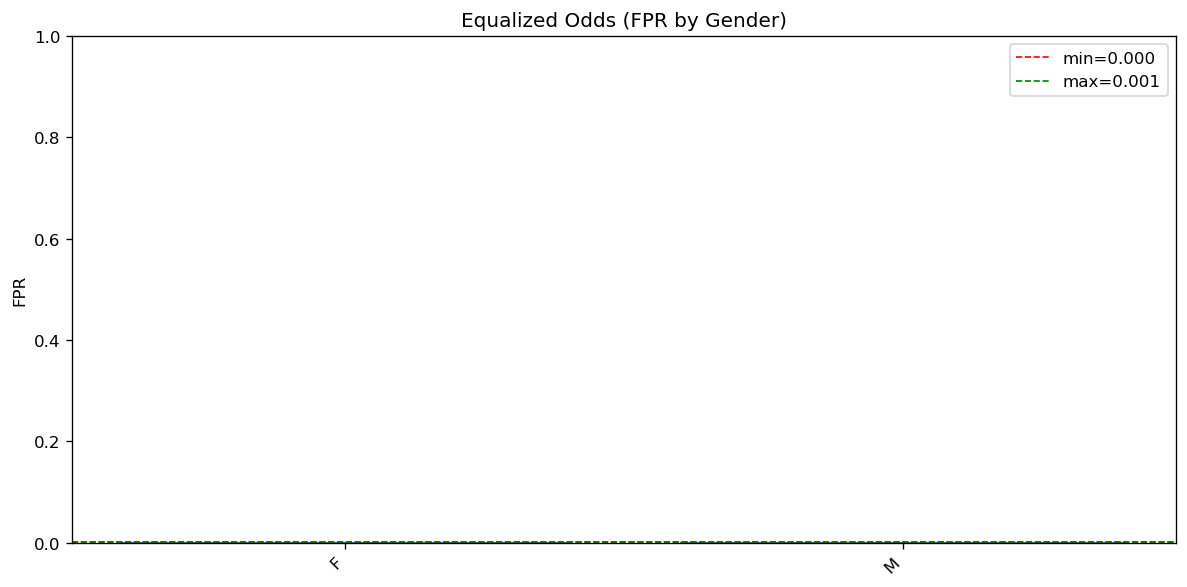

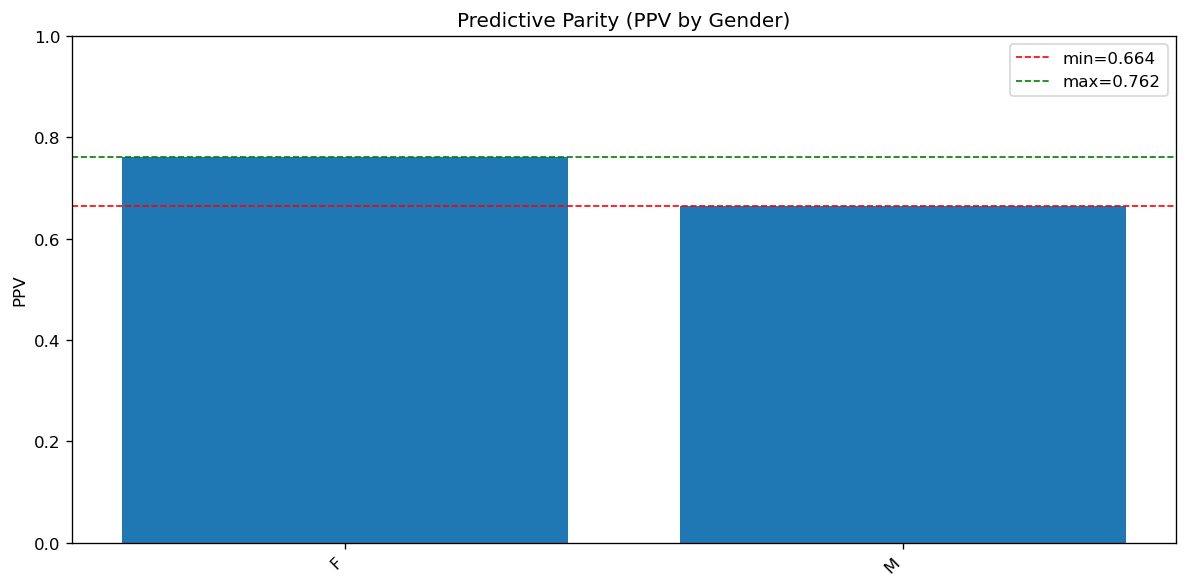

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def plot_group_fairness(group_df, group_cols, metric, title=None):
    """
    group_df: output from group_fairness_metrics (per subgroup).
    group_cols: list of grouping variables (e.g. ["gender"], ["race_standard"], ["gender","race_standard"]).
    metric: one of 'selection_rate', 'TPR', 'FPR', 'PPV'.
    """
    if isinstance(group_cols, str):
        group_cols = [group_cols]
    labels = group_df[group_cols].astype(str).agg(" • ".join, axis=1).tolist()
    vals = group_df[metric].values

    plt.figure(figsize=(10,5))
    bars = plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), labels, rotation=45, ha="right")
    plt.ylim(0,1)
    plt.ylabel(metric)
    plt.title(title or f"{metric} by " + " × ".join(group_cols))

    # Highlight min/max lines
    vmin, vmax = np.nanmin(vals), np.nanmax(vals)
    plt.axhline(vmin, color="red", linestyle="--", linewidth=1, label=f"min={vmin:.3f}")
    plt.axhline(vmax, color="green", linestyle="--", linewidth=1, label=f"max={vmax:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: visualize gender fairness
plot_group_fairness(fair_gender, "gender", "selection_rate", "Demographic Parity (Selection Rate by Gender)")
plot_group_fairness(fair_gender, "gender", "TPR", "Equal Opportunity (TPR by Gender)")
plot_group_fairness(fair_gender, "gender", "FPR", "Equalized Odds (FPR by Gender)")
plot_group_fairness(fair_gender, "gender", "PPV", "Predictive Parity (PPV by Gender)")


In [76]:
def group_calibration_gap(group_df):
    """
    Adds a calibration gap column = |PPV - prevalence| for each group.
    """
    df = group_df.copy()
    df["calibration_gap"] = (df["PPV"] - df["prevalence"]).abs()
    return df

# Example: gender calibration
fair_gender_cal = group_calibration_gap(fair_gender)
display(fair_gender_cal[["gender","PPV","prevalence","calibration_gap"]])


,gender,PPV,prevalence,calibration_gap
0,F,0.761905,0.018082,0.743823
1,M,0.664122,0.028052,0.636070


,n,deaths,mortality_rate
expanded_symptoms_new,,,
failure,1,1,1.000000
cardiac arrest,430,302,0.702326
upper respiratory infection,3,1,0.333333
sepsis,134,34,0.253731
cerebrovascular accident,785,129,0.164331
jaundice,905,147,0.162431
failure to thrive,797,127,0.159348
hypotension,2335,290,0.124197
gastrointestinal hemorrhage,689,69,0.100145


In [80]:
# ===== Step 2: Performance metrics by symptom =====
metrics_by_symptom = compute_metrics_by_group(
    df_clean,
    y_col="died_within_30_days",
    prob_col="mortality_prob",
    group_col=symptom_col,
    threshold=0.5
)

# Merge with prevalence info
metrics_with_prev = metrics_by_symptom.merge(
    symptom_stats.reset_index()[[symptom_col,"mortality_rate"]],
    on=symptom_col,
    how="left"
)

# Sort by prevalence (deadliest first)
metrics_with_prev = metrics_with_prev.sort_values("mortality_rate", ascending=False)
display(metrics_with_prev.head(20))


,expanded_symptoms_new,n,TP,FP,TN,FN,Accuracy,Recall,Specificity,Precision,F1,ROC AUC,PR AUC,mortality_rate
7,cardiac arrest,430,302,128,0,0,0.702326,1.0,0.0,0.702326,0.825137,0.632812,0.794308,0.702326
60,upper respiratory infection,3,0,0,2,1,0.666667,0.0,1.0,0.000000,0.000000,1.000000,1.000000,0.333333
52,sepsis,134,0,0,100,34,0.746269,0.0,1.0,0.000000,0.000000,0.650882,0.416988,0.253731
8,cerebrovascular accident,785,0,0,656,129,0.835669,0.0,1.0,0.000000,0.000000,0.729982,0.303976,0.164331
39,jaundice,905,0,0,758,147,0.837569,0.0,1.0,0.000000,0.000000,0.588857,0.196087,0.162431
25,failure to thrive,797,0,0,670,127,0.840652,0.0,1.0,0.000000,0.000000,0.605400,0.218559,0.159348
37,hypotension,2335,0,0,2045,290,0.875803,0.0,1.0,0.000000,0.000000,0.625236,0.186114,0.124197
30,gastrointestinal hemorrhage,689,0,0,620,69,0.899855,0.0,1.0,0.000000,0.000000,0.567859,0.141222,0.100145
38,hypothermia,62,0,0,56,6,0.903226,0.0,1.0,0.000000,0.000000,0.697917,0.275514,0.096774
2,ascites,84,0,0,76,8,0.904762,0.0,1.0,0.000000,0.000000,0.377467,0.080621,0.095238


In [82]:
# ===== Step 3: Fairness metrics by symptom × gender =====
top_symptoms = symptom_stats.head(5).index.tolist()  # pick top 5 deadliest

for sym in top_symptoms:
    sub = df_clean[df_clean[symptom_col] == sym]
    print(f"\n=== Symptom: {sym} (n={len(sub)}) ===")
    fair_sym_gender, gaps_sym_gender = group_fairness_metrics(
        sub, y_col=y_col, prob_col="mortality_prob", group_cols="gender", threshold=0.5
    )
    display(fair_sym_gender)
    print("Fairness gaps:", gaps_sym_gender)



=== Symptom: failure (n=1) ===


""


Fairness gaps: {}

=== Symptom: cardiac arrest (n=430) ===


,gender,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,F,168,128,40,0,0,1.0,1.0,1.0,0.761905,NaN,0.761905
1,M,262,174,88,0,0,1.0,1.0,1.0,0.664122,NaN,0.664122


Fairness gaps: {'DP_diff (max-min selection rate)': 0.0, 'DP_ratio (min/max selection rate)': 1.0, 'EO_diff (max-min TPR)': 0.0, 'EO_ratio (min/max TPR)': 1.0, 'EOdds_TPR_diff (max-min TPR)': 0.0, 'EOdds_FPR_diff (max-min FPR)': 0.0, 'PPV_parity_diff (max-min PPV)': 0.09778262450018171, 'PPV_parity_ratio (min/max PPV)': 0.8716603053435115}

=== Symptom: upper respiratory infection (n=3) ===


,gender,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,F,3,0,0,2,1,0.0,0.0,0.0,NaN,0.666667,0.333333


Fairness gaps: {'DP_diff (max-min selection rate)': 0.0, 'DP_ratio (min/max selection rate)': nan, 'EO_diff (max-min TPR)': 0.0, 'EO_ratio (min/max TPR)': nan, 'EOdds_TPR_diff (max-min TPR)': 0.0, 'EOdds_FPR_diff (max-min FPR)': 0.0, 'PPV_parity_diff (max-min PPV)': nan, 'PPV_parity_ratio (min/max PPV)': nan}

=== Symptom: sepsis (n=134) ===


,gender,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,F,54,0,0,38,16,0.0,0.0,0.0,NaN,0.703704,0.296296
1,M,80,0,0,62,18,0.0,0.0,0.0,NaN,0.775000,0.225000


Fairness gaps: {'DP_diff (max-min selection rate)': 0.0, 'DP_ratio (min/max selection rate)': nan, 'EO_diff (max-min TPR)': 0.0, 'EO_ratio (min/max TPR)': nan, 'EOdds_TPR_diff (max-min TPR)': 0.0, 'EOdds_FPR_diff (max-min FPR)': 0.0, 'PPV_parity_diff (max-min PPV)': nan, 'PPV_parity_ratio (min/max PPV)': nan}

=== Symptom: cerebrovascular accident (n=785) ===


,gender,n,TP,FP,TN,FN,selection_rate,TPR,FPR,PPV,NPV,prevalence
0,F,428,0,0,347,81,0.0,0.0,0.0,NaN,0.810748,0.189252
1,M,357,0,0,309,48,0.0,0.0,0.0,NaN,0.865546,0.134454


Fairness gaps: {'DP_diff (max-min selection rate)': 0.0, 'DP_ratio (min/max selection rate)': nan, 'EO_diff (max-min TPR)': 0.0, 'EO_ratio (min/max TPR)': nan, 'EOdds_TPR_diff (max-min TPR)': 0.0, 'EOdds_FPR_diff (max-min FPR)': 0.0, 'PPV_parity_diff (max-min PPV)': nan, 'PPV_parity_ratio (min/max PPV)': nan}


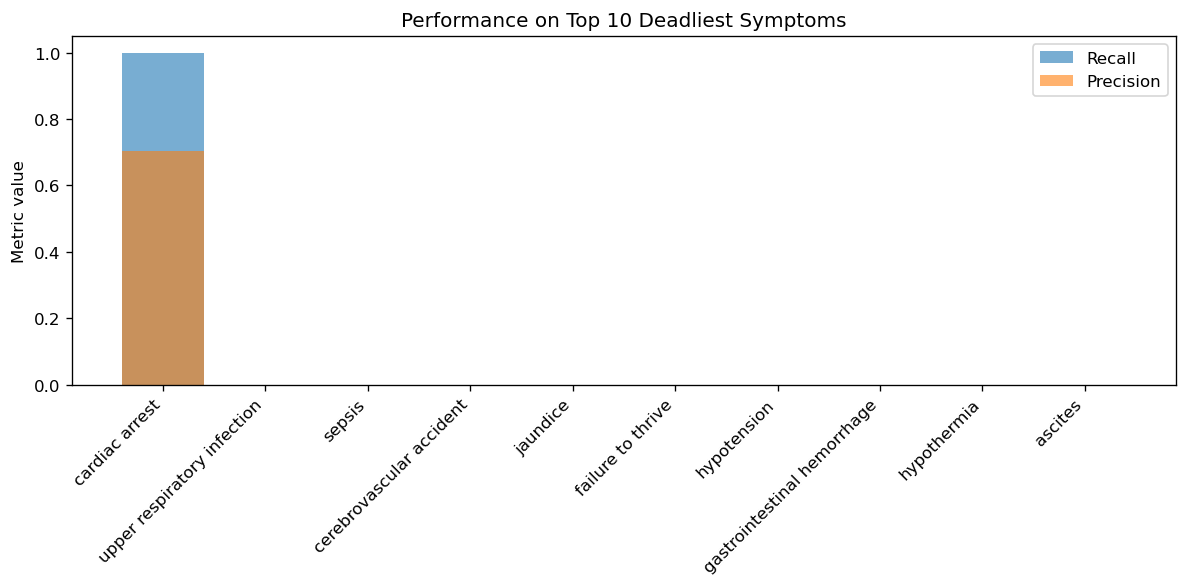

In [84]:
# ===== Step 4: Plot recall & precision per symptom =====
import matplotlib.pyplot as plt

topN = 10
subset = metrics_with_prev.head(topN)

plt.figure(figsize=(10,5))
plt.bar(subset[symptom_col], subset["Recall"], alpha=0.6, label="Recall")
plt.bar(subset[symptom_col], subset["Precision"], alpha=0.6, label="Precision")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Metric value")
plt.title(f"Performance on Top {topN} Deadliest Symptoms")
plt.legend()
plt.tight_layout()
plt.show()
